# Classification of Lego bricks: classificazione di blocchi Lego in diverse posizioni
&nbsp;
### Laure magistrale in ingegneria e scienze informatiche
### Progetto di Fondamenti di Machine learning
### Docente: Marco Cristiani
### Anno accademico: 2023-2024
&nbsp;
##### Autore: Lorenzo Genghini
##### Matricola: VR463396

### Indice del notebook:
1. Introduzione

    * Librerie utilizzate

2. Dataset

    * Ridimensionamento e conversione in scala di grigi

    * Caricamento del dataset di Training e Testing

3. Linear discriminant analysis (LDA)

    * Estrazione delle features

    * Riduzione della dimensionalità

4. Classificazione

    * KNN (K-Nearest Neighbor)

    * SVM (Support vector machines)
5. Conclusioni

    * Blocchi Lego classificati meglio e peggio

    * Progetti futuri

## 1 Introduzione
In questo progetto si eseguirà la classificazione di differenti blocchi Lego andando da prima ad estrarre le features e ridurre la dimensionalità dei dati di training e poi in seguito ad eseguire la classificazione dei campioni di testing utilizzando l’algoritmo K-Nearest Neighbor (KNN) con differenti valori per K (3, 5 e 7) e l’algoritmo Support vector machines (SVM) con differenti tipi di kernel (lineare, polinomiale e Radial Basis Function (RBF)).

Come risultato, vorrei capire se questi due algoritmi selezionati per la classificazione sono adatti a identificare i diversi blocchi Lego e se possono essere impiegati in ambito lavorativo.

#### 1.1 Librerie utilizzate
Le librerie utilizzate all’interno di questo progetto sono le seguenti:
* os, utile per trovare le directory 
* numpy, utile per fare calcoli matematici e creare array
* Image, utile per lavorare con le immagini
* matplotlib.pyplot, utile per creare grafici
* sklearn, utile per implementare gli algoritmi LDA, KNN e SVM e stampare i risultati ottenuti con la classificazione.

In [1]:
# Importo le librerie utilizzate per il caricamento dei campioni
import os
import numpy as np
from PIL import Image

# Importo le librerie utilizzate per eseguire LDA e stampare i dati ottenuti
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Importo le librerie utilizzata per stampare i dati ottenuti con la classificazione
from sklearn.metrics import classification_report, confusion_matrix

# Importo la libreria utilizzata per eseguire KNN
from sklearn.neighbors import KNeighborsClassifier

# Importo la libreria utilizzata per eseguire SVM
from sklearn import svm

## 2 Dataset
Il dataset utilizzato per la realizzazione di questo progetto si chiama “Images of LEGO Bricks” ed è stato preso dal sito web Kaggle. Esso, è formato da diversi blocchi Lego fotografati in differenti posizioni.

Di seguito vado a verificare che nella cartella del dataset siano presenti le sottocartelle di train e test

In [2]:
# Definisco il percorso del dataset
root_path = "Lego_Bricks_Dataset"

# Verifico che il dataset sia suddiviso in train e test
subdirs = os.listdir(root_path)

# Stampo le cartelle trovate nella directory
print("Sottocartelle:")
print(subdirs)

# Elimino gli oggetti non più necessari
del subdirs

Sottocartelle:
['Test', 'Train']


#### 2.1 Ridimensionamento e conversione in scala di grigi
Per prima cosa creo la funzione che conta il numero delle immagini presenti nel dataset 

In [3]:
def image_counter(dirpath):
    n_images = 0

    # Conto tutte le immagini presenti nella directory selezionata
    for _, _, filenames in os.walk(root_path + os.path.sep + dirpath):
        n_images += len(filenames)

    return n_images

Dopo di che creo la funzione che carica i dati di ogni partizione del dataset in due vettori:
* il **samples_vector** che contiene le immagini e ha una dimensione uguale al _numero delle features_ per il _numero dei campioni_
* il **labels_vector** che contiene le classi delle immagini e ha una dimensione uguale al _numero dei campioni_.

In oltre, tutte le immagini vengono ridimensionate alla dimensione image_shape per renderle uniformi e i pixel sono convertiti in scala di grigi nel range 0..1, così da avere una riduzione della dimensionalità per questioni di performance e rendere la classificazione indipendente dal colore.

**Tabella delle labels**
|Valore|Classe|
|:---:|:---|
|0|blocco 1x1|
|1|blocco 1x2|
|2|blocco 2x2|
|3|blocco con frizione e asse incrociato 2m|
|4|blocco ad angolo 1x2x2|
|5|blocco piatto liscio 1x2|
|6|blocco a piolo 2m|
|7|blocco piatto 1x1|
|8|blocco piatto 1x2|
|9|blocco piatto 2x2|
|10|blocco piatto con pomello 1X2|
|11|blocco tetto tegola 1x2|
|12|blocco tecnico leva 3m|

In [4]:
def image_loader(dirpath, image_shape):
    
    # Identifico il numero di immagini nella directory selezionata
    n_images = image_counter(dirpath)

    # Vettore che conterrà i campioni
    samples_vector = np.zeros((image_shape[0] * image_shape[1], n_images), dtype="float32")
    # Vettore che conterrà la classe dei campioni
    labels_vector = np.zeros(n_images, dtype="uint8")

    # Variabile che tiene il conteggio della colonna a cui si è arrivati
    column_index = 0

    for subdirpath, _, filenames in os.walk(root_path + os.path.sep + dirpath):
        # Prelevo i nomi delle cartelle presenti in "dirpath"
        label_string = subdirpath.split(os.path.sep)[-1]

        # Assegno una label a ciascuna classe nel mio dataset
        if label_string == "brick_1x1":
            label = 0
        elif label_string == "brick_1x2":
            label = 1
        elif label_string == "brick_2x2":
            label = 2
        elif label_string == "brick_bush_friction_with_cross_axle_2m":
            label = 3
        elif label_string == "brick_corner_1x2x2":
            label = 4
        elif label_string == "brick_flat_tile_1x2":
            label = 5
        elif label_string == "brick_peg_2m":
            label = 6
        elif label_string == "brick_plate_1x1":
            label = 7
        elif label_string == "brick_plate_1x2":
            label = 8
        elif label_string == "brick_plate_2x2":
            label = 9
        elif label_string == "brick_plate_knob_1X2":
            label = 10
        elif label_string == "brick_roof_tile_1x2":
            label = 11
        elif label_string == "brick_technic_lever_3m":
            label = 12

        # Controllo che la label non corrisponda al dirpath 
        if label_string != dirpath:
            for file in filenames:
                # Apro un immagine
                img = Image.open(subdirpath + os.path.sep + file)
                
                # Ridimensiono l'immagine e la converto in scala di grigi a 8-bit [0..255]
                img = img.resize(im_shape).convert('L')
                
                # Converto l'immagine in un vettore colonna e scalo i dati in un range compreso tra 0..1
                sample = (np.array(img).reshape(-1) / 255.0).astype("float32")
                
                # Chiudo l'immagine aperta in precedenza
                img.close()
    
                # Salvo il novo sample ottenuto dall'immagine scalata
                samples_vector[:, column_index] += sample
                # Salvo il label del sample ottenuto
                labels_vector[column_index] += label

                # Aggiorno l'indice della colonna
                column_index += 1

    # Restituisco i samples ottenuti e i relativi labels
    return samples_vector, labels_vector

#### 2.2 Caricamento del dataset di Training e Testing
A questo punto, carico i dataset di training e testing che conterranno al loro interno tredici classi rappresentanti i diversi pezzi Lego

In [5]:
# Definisco la risoluzione che dovranno avere le immagini
im_shape = (100, 100)

# Calcolo il vettore dei samples e dei labels
train_samples, train_labels = image_loader("Train", im_shape)
test_samples, test_labels = image_loader("Test", im_shape)

## 3 Linear discriminant analysis (LDA)

La Linear Discriminant Analysis (o Fisher Discriminant Analysis) è una procedura di estrazione delle features che esegue proiezioni lineari e fornisce un grado di informazione maggiore sulle classi degli oggetti.

#### 3.1 Estrazione delle features

In questa prima sezione si andrà ad eseguire il fit del modello, cioè ad estrarre le features. L’estrazione delle features avviene utilizzando il vettore di training contenente i campioni e il vettore delle etichette.

In [6]:
# Inizializzo LDA
lda = LinearDiscriminantAnalysis()

# Eseguo LDA inserendo i samples e i labels ricavati in precedenza
fit_samples = lda.fit(train_samples.T, train_labels)

#### 3.2 Riduzione della dimensionalità

A questo punto, dopo aver eseguito l’estrazione delle features, si prosegue con la proiezione dei dati su di un unico asse, così da massimizzare la distanza tra le classi (cioè la distanza tra le medie) e minimizzare la varianza di ciascuna classe (cioè avere delle classi compatte).

In [7]:
# Eseguo la proiezione dei dati per massimizzare la separazione tra le classi
transformed_samples = fit_samples.transform(train_samples.T)

In fine, verifico graficamente la disposizione dei dati ottenuti.

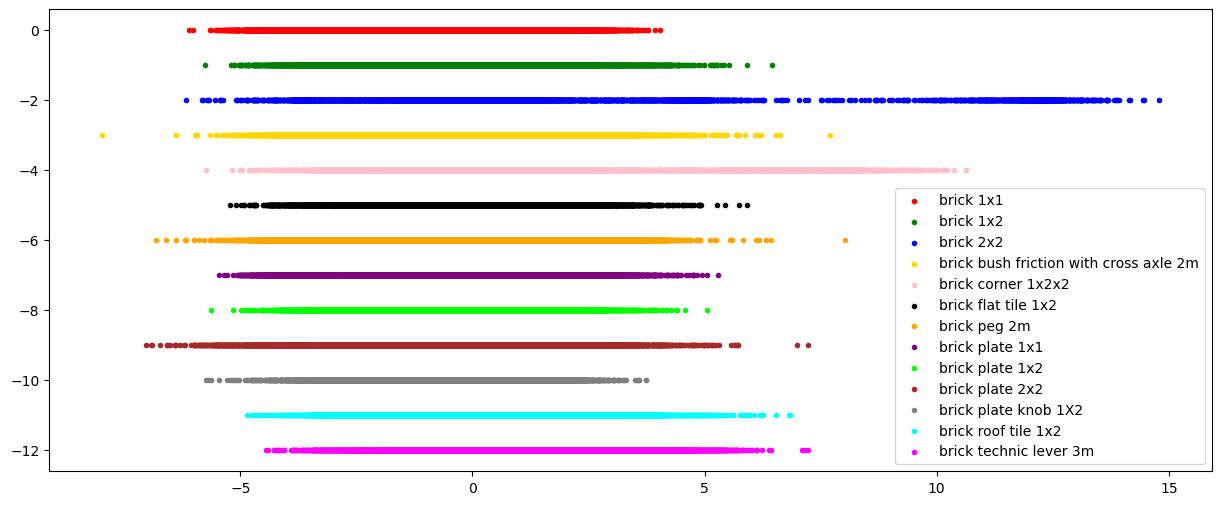

In [8]:
# Setto la dimensione dell'immagine
fig = plt.figure(figsize=(15,6))
ax = plt.subplot()

# Separo i dati di ogni classe
transformed_brick_1x1_samples = np.squeeze(transformed_samples[train_labels == 0])
transformed_brick_1x2_samples = np.squeeze(transformed_samples[train_labels == 1])
transformed_brick_2x2_samples = np.squeeze(transformed_samples[train_labels == 2])
transformed_brick_bush_friction_with_cross_axle_2m_samples = np.squeeze(transformed_samples[train_labels == 3])
transformed_brick_corner_1x2x2_samples = np.squeeze(transformed_samples[train_labels == 4])
transformed_brick_flat_tile_1x2_samples = np.squeeze(transformed_samples[train_labels == 5])
transformed_brick_peg_2m_samples = np.squeeze(transformed_samples[train_labels == 6])
transformed_brick_plate_1x1_samples = np.squeeze(transformed_samples[train_labels == 7])
transformed_brick_plate_1x2_samples = np.squeeze(transformed_samples[train_labels == 8])
transformed_brick_plate_2x2_samples = np.squeeze(transformed_samples[train_labels == 9])
transformed_brick_plate_knob_1X2_samples = np.squeeze(transformed_samples[train_labels == 10])
transformed_brick_roof_tile_1x2_samples = np.squeeze(transformed_samples[train_labels == 11])
transformed_brick_technic_lever_3m_samples = np.squeeze(transformed_samples[train_labels == 12])

# Stampo i dati di ogni classe per vederne la disposizione
ax.scatter(transformed_brick_1x1_samples, np.full(transformed_brick_1x1_samples.size, 0), marker=".", label='brick 1x1', c='red')
ax.scatter(transformed_brick_1x2_samples, np.full(transformed_brick_1x2_samples.size, -1), marker=".", label='brick 1x2', c='green')
ax.scatter(transformed_brick_2x2_samples, np.full(transformed_brick_2x2_samples.size, -2), marker=".", label='brick 2x2', c='blue')
ax.scatter(transformed_brick_bush_friction_with_cross_axle_2m_samples, np.full(transformed_brick_bush_friction_with_cross_axle_2m_samples.size, -3), marker=".", label='brick bush friction with cross axle 2m', c='gold')
ax.scatter(transformed_brick_corner_1x2x2_samples, np.full(transformed_brick_corner_1x2x2_samples.size, -4), marker=".", label='brick corner 1x2x2', c='pink')
ax.scatter(transformed_brick_flat_tile_1x2_samples, np.full(transformed_brick_flat_tile_1x2_samples.size, -5), marker=".", label='brick flat tile 1x2', c='black')
ax.scatter(transformed_brick_peg_2m_samples, np.full(transformed_brick_peg_2m_samples.size, -6), marker=".", label='brick peg 2m', c='orange')
ax.scatter(transformed_brick_plate_1x1_samples, np.full(transformed_brick_plate_1x1_samples.size, -7), marker=".", label='brick plate 1x1', c='purple')
ax.scatter(transformed_brick_plate_1x2_samples, np.full(transformed_brick_plate_1x2_samples.size, -8), marker=".", label='brick plate 1x2', c='lime')
ax.scatter(transformed_brick_plate_2x2_samples, np.full(transformed_brick_plate_2x2_samples.size, -9), marker=".", label='brick plate 2x2', c='brown')
ax.scatter(transformed_brick_plate_knob_1X2_samples, np.full(transformed_brick_plate_knob_1X2_samples.size, -10), marker=".", label='brick plate knob 1X2', c='gray')
ax.scatter(transformed_brick_roof_tile_1x2_samples, np.full(transformed_brick_roof_tile_1x2_samples.size, -11), marker=".", label='brick roof tile 1x2', c='cyan')
ax.scatter(transformed_brick_technic_lever_3m_samples, np.full(transformed_brick_technic_lever_3m_samples.size, -12), marker=".", label='brick technic lever 3m', c='magenta')

# Inserisco la leggenda nell'immagine
plt.legend(loc='lower right')
# Mostro l'immagine
plt.show()

Come si può osservare dall’immagine soprastante, sono presenti diversi outliers per ciascuna classe.

Di seguito vado a mostrare gli outliers più significativi.

<Figure size 640x480 with 0 Axes>

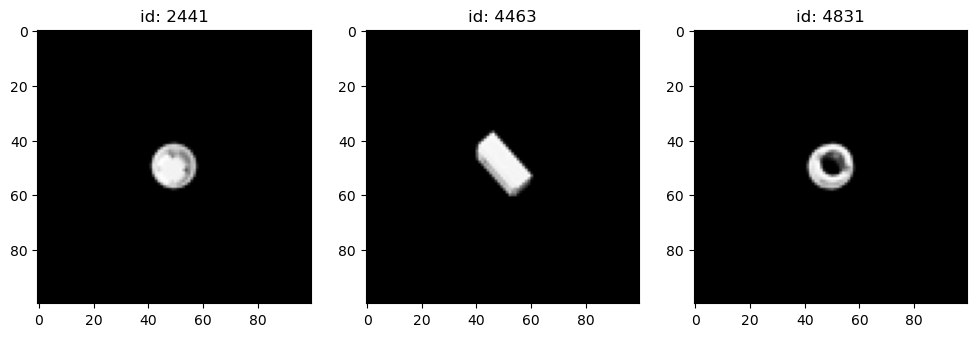

In [9]:
# Stampo gli outliers più significativi
# Brick bush friction with cross axle 2m
fake_bbfwca_2m = np.nonzero((train_labels.size) * np.squeeze(transformed_samples < -7))[0]
# Brick flat tile 1x2
fake_bft_1x2 = np.nonzero((train_labels.size) * np.squeeze(transformed_samples > 5.5))[0]
# Brick peg 2m
fake_bp_2m = np.nonzero((train_labels.size) * np.squeeze(transformed_samples > 8))[0]

# Setto le immagini che stamperò in scala di grigi
plt.set_cmap("gray")
# Setto la dimensione dell'immagine
plt.figure(figsize=(12,6))

# Inizializzo la variabile che mi indica i subplot totali
subplot_index = 0
# Inizializzo l'array che conterrà gli indici degli ouliers
outliers = []

# Trovo gli outliers per i brick bush friction with cross axle 2m
for i in range(1, fake_bbfwca_2m.size + 1):
    image_index = fake_bbfwca_2m[i-1]
    
    if train_labels[image_index] == 3:
        outliers.append(image_index)

# Trovo gli outliers per i brick flat tile 1x2
for i in range(1, fake_bft_1x2.size + 1):
    image_index = fake_bft_1x2[i-1]
    
    if train_labels[image_index] == 5:
        outliers.append(image_index)
        break

# Trovo gli outliers per i brick peg 2m
for i in range(1, fake_bp_2m.size + 1):
    image_index = fake_bp_2m[i-1]
    
    if train_labels[image_index] == 6:
        outliers.append(image_index)

# Mostro gli outliers trovati e i relativi indici
for i in range(1, len(outliers) + 1):
    plt.subplot(1, len(outliers), i)
    plt.title(f"id: {outliers[i-1]}")
    plt.imshow(train_samples[:, outliers[i-1]].reshape(im_shape))

Gli outliers visualizzati qui sopra, come possiamo vedere, rappresentano immagini ambigue anche per l'occhio umano.

## 4 Classificazione

La classificazione sarà eseguita con gli algoritmi _K-Nearest Neighbors_ e _Support Vector Machine_.

Essa si comporrà di due fasi:
* Nella prima, verrà eseguito l’addestramento del classificatore utilizzando i dati precedentemente ridotti di dimensionalità con LDA
* Nella seconda, si andrà a classificare il dataset di test.

Di seguito viene riportata la funzione che stamperà i risultati ottenuti con la classificazione.

In [10]:
def print_report(report):
    # Stampo l'accuracy
    print("Accuracy: " + f"{report['accuracy']:0,.2f}")
    
    # Stampo i valori di precision, recall e support
    print("\n    Precision    Recall   Support\n")
    for n in range(0, 13):
    
        if n < 10:
            print(f" {n}" + f"       {report[str(n)]['precision']:0,.2f}" + f"      {report[str(n)]['recall']:0,.2f}" + f"       {report[str(n)]['support']:0,.0f}")
        else:
            print(f"{n}" + f"       {report[str(n)]['precision']:0,.2f}" + f"      {report[str(n)]['recall']:0,.2f}" + f"       {report[str(n)]['support']:0,.0f}")
    
    # Stampo la matrice di confusione
    print("\nMatrice di confusione:")
    print(confusion_matrix(test_labels, predict_labels))
    
    print()
    print("--------------------------------------------------------")
    print()

#### 4.1 KNN (K-Nearest Neighbor)

Il K-Nearest Neighbor (KNN) è un algoritmo che parte dall'idea che oggetti simili saranno vicini  anche nello spazio delle features. Il problema di questo approccio sta nel determinare opportunamente K.

Di seguito, implemento l’algoritmo e setto tre diversi valori per K, così da poter confrontare i risultati ottenuti e definire quale valore da il miglior risultato in fase di classificazione.

In [11]:
# Assegno un nome più significativo ai campioni di train 
transformed_samples_train = transformed_samples

# Eseguo la proiezione dei campioni di test
transformed_samples_test = lda.transform(test_samples.T)

# Setto i valori che può assumere K
k_values = [3, 5, 7]
# Eseguo la classificazione con KNN
for k in k_values:
    # Inizializzo KNN
    KNN = KNeighborsClassifier(n_neighbors=k)
    # Eseguo KNN
    classifier_KNN = KNN.fit(transformed_samples_train, train_labels)
    # Eseguo la predizione sui campioni di test
    predict_labels = classifier_KNN.predict(transformed_samples_test)

    # Stampo il valore di K con cui ho eseguito la classificazione
    print(f"K = {k}")
    # Trasformo il report di classificazione in un dizionario per formattare i dati a mio piacimento
    print_report(classification_report(test_labels, predict_labels, output_dict=True))

K = 3
Accuracy: 0.19

    Precision    Recall   Support

 0       0.04      0.04       400
 1       0.08      0.07       400
 2       0.22      0.85       400
 3       0.92      0.95       400
 4       0.12      0.27       400
 5       0.02      0.01       400
 6       0.03      0.01       400
 7       0.48      0.10       400
 8       0.01      0.00       400
 9       0.03      0.04       400
10       0.06      0.01       400
11       0.08      0.07       400
12       0.05      0.04       400

Matrice di confusione:
[[ 14 110  15   4  24  15   5   0  21  82  15  93   2]
 [ 14  30 156   5  95   3  11   3   5  31   3  16  28]
 [  1   4 342   0  30   0   7   0   1  15   0   0   0]
 [  0   0   0 381   0   1  16   0   0   0   2   0   0]
 [  8  18 216   0 106   1   6   0   0  32   3   3   7]
 [ 15  23 103   3 102   2   5   3   1  64   1  38  40]
 [  6  37  30   4  28  60   3  30  18  56  16  33  79]
 [240  20   0   7   1  10   0  39  15   1  17  44   6]
 [ 16  42  84   5  74   3   4   4   1

Da come si può osservare dai risultati qui sopra riportati, per tutti e tre i valori di K si ha un accuratezza nella classificazione pari a 0,19. D’altra parte però, confrontando i dati della precision, recall  e matrice di confusione si può osservare che solamente per K uguale a 3 la classificazione dei campioni di test è leggermente più ottimale.

#### 4.2 SVM (Support vector machines)

Le Support Vector Machines (SVM) sono dei modelli di apprendimento supervisionato con l’obbiettivo di trovare un iperpiano che separa i dati di una classe da quelli di un’altra.

Di seguito, implemento l’algoritmo e setto tre diversi kernel, così da poter confrontare i risultati ottenuti e definire quale kernel da il miglior risultato in fase di classificazione.

I Kernel utilizzati per la classificazione sono i seguenti:
* Lineare
* Polinomiale, che ha il grado del polinomio impostato a 3 di default
* Radial Basis Function (RBF), che ha la larghezza del kernel impostata a '_scale_' di default (_1 / (numero delle features * varianza dei campioni)_).

In [12]:
# Assegno un nome più significativo ai campioni di train 
transformed_samples_train = transformed_samples

# Eseguo la proiezione dei campioni di test
transformed_samples_test = lda.transform(test_samples.T)

# Setto i kernel che utilizzerò per eseguire la classificazione
kernel_svm = ['linear', 'poly', 'rbf']
# Eseguo la classificazione con SVM
for k in kernel_svm:
    # Inizializzo SVM
    SVM = svm.SVC(kernel=k)
    # Eseguo SVM
    classifier_SVM = SVM.fit(transformed_samples_train, train_labels)
    # Eseguo la predizione sui campioni di test
    predict_labels = classifier_SVM.predict(transformed_samples_test)

    # Stampo il kernel che sto usando per eseguire la classificazione
    print(f"Kernel = {k}")
    # Trasformo il report di classificazione in un dizionario per formattare i dati a mio piacimento
    print_report(classification_report(test_labels, predict_labels, output_dict=True))

Kernel = linear
Accuracy: 0.17

    Precision    Recall   Support

 0       0.02      0.02       400
 1       0.08      0.10       400
 2       0.22      0.83       400
 3       0.82      0.90       400
 4       0.12      0.17       400
 5       0.04      0.01       400
 6       0.02      0.01       400
 7       0.16      0.08       400
 8       0.09      0.01       400
 9       0.03      0.04       400
10       0.06      0.01       400
11       0.04      0.02       400
12       0.06      0.04       400

Matrice di confusione:
[[  9 121  27   6  31  14  11   0  17  75  13  71   5]
 [ 22  38 138  16  51   6  47  29   3  20   5  12  13]
 [  2   4 334   9   5   0  17   1   0  16   0   0  12]
 [  0   0   0 359   0   1  32   0   0   0   8   0   0]
 [  9  32 212   2  66   2  42  14   1   9   2   5   4]
 [ 20  39 105   1  77   5  13  21   2  64   4  25  24]
 [  8  33  31   5  21  61   6  46  19  46  11  24  89]
 [223  44   0   7   0   9   0  32  12   1  18  49   5]
 [ 26  50  75  11  60   5  

Da come si può osservare dai risultati qui sopra riportati, utilizzando il kernel lineare e polinomiale si ha un’accuratezza migliore in fase di classificazione pari a 0,17. D’altra parte però, confrontando i dati della precision, recall  e matrice di confusione si può osservare che solamente il kernel lineare garantisce una classificazione dei campioni di test leggermente più ottimale.

## 5 Conclusioni
Come si può osservare dal progetto svolto, la classificazione dei blocchi Lego avviene in maniera più ottimale sfruttando l’algoritmo K-Nearest Neighbor (KNN) con un valore per K uguale a 3. Invece, per quanto riguarda l’algoritmo Support vector machines (SVM), si è visto che la classificazione con esso non è molto ottimale e peggiora utilizzando un kernel Radial Basis Function (RBF).

#### 5.1 Blocchi Lego classificati meglio e peggio

Il blocco Lego classificato meglio in fase di test da entrambi gli algoritmi è stato: 
* il "_blocco con frizione e asse incrociato 2m_".
 
Invece, i blocchi Lego classificati peggio per KNN sono stati:
* il "_blocco piatto 1x2_" che è stato identificato più volte come "_blocco piatto 2x2_"

e per SVM:
* il "_blocco piatto liscio 1x2_" che è stato identificato più volte come "_blocco 2x2_"
* il "_blocco piatto con pomello 1X2_" che è stato identificato più volte come "_blocco piatto 2x2_".

#### 5.2 Progetti futuri
In conclusione, sarebbe opportuno cercare un algoritmo di classificazione più ottimale per i blocchi Lego, così da ottenere un miglior riconoscimento di questi ultimi e ridurre al minimo la possibilità di errore in fase di classificazione. Inoltre, questa ottimizzazione potrebbe tornare utile in ambito lavorativo per riconoscere i diversi tipi di blocchi Lego e separarli correttamente gli uni dagli altri.